<a href="https://colab.research.google.com/github/arnabbiswas66/multimodal-fake-news-classifier/blob/main/Weibo_multimodal_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q tensorflow_text

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 25.7 MB/s eta 0:00:00


In [2]:
from tensorflow.python.platform.tf_logging import warn
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
import os
import re
from os import listdir
import shutil
import glob
import random
import matplotlib.pyplot as plt
import tensorflow_hub as hub
import tensorflow_text as text
#from official.nlp import optimization  # to create AdamW optimizer
tf.get_logger().setLevel('ERROR')
import warnings

warnings.filterwarnings('ignore')

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
BASE_SAVE_LOCATION = "/content/drive/MyDrive/multimodal-news"

In [5]:
def get_df(file):
    return pd.read_csv(file, sep='|',header = None)

In [6]:
train_df_fake = get_df('/content/drive/MyDrive/multimodal-news/weibo-data/tweets/train_rumor.txt')
train_df_real = get_df('/content/drive/MyDrive/multimodal-news/weibo-data/tweets/train_nonrumor.txt')
test_df_fake = get_df('/content/drive/MyDrive/multimodal-news/weibo-data/tweets/test_rumor.txt')
test_df_real = get_df('/content/drive/MyDrive/multimodal-news/weibo-data/tweets/test_nonrumor.txt')

In [7]:
train_df_fake.shape, train_df_real.shape, test_df_fake.shape, test_df_real.shape

((11194, 15), (11349, 15), (2934, 15), (2988, 15))

In [8]:
test_df_real.tail()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
2983,http://ww3.sinaimg.cn/large/61e04755jw1ewkm8o7...,http://ww1.sinaimg.cn/large/61e04755jw1ewkm8or...,http://ww1.sinaimg.cn/large/61e04755jw1ewkm8pj...,http://ww1.sinaimg.cn/large/61e04755jw1ewkm8q1...,http://ww4.sinaimg.cn/large/61e04755jw1ewkm8qo...,http://ww3.sinaimg.cn/large/61e04755jw1ewkm8rb...,http://ww4.sinaimg.cn/large/61e04755jw1ewkm8rt...,http://ww1.sinaimg.cn/large/61e04755jw1ewkm8sq...,http://ww1.sinaimg.cn/large/61e04755jw1ewkm8t6...,NaN,NaN,NaN,NaN,NaN,NaN
2984,【现场图·广西柳城县连续发生多起爆炸】据@南宁电视台 ：网友称，现场听到几声巨响，车站，市场...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2985,3891020422521038,NaN,NaN,NaN,1443175023000,true,36,7,35,NaN,0.0,NaN,NaN,NaN,微博 weibo.com
2986,http://ww3.sinaimg.cn/large/005EHRy1jw1ewetx1s...,http://ww1.sinaimg.cn/large/005EHRy1jw1ewetx2j...,http://ww3.sinaimg.cn/large/005EHRy1jw1ewetx33...,http://ww4.sinaimg.cn/large/005EHRy1jw1ewetx3o...,http://ww4.sinaimg.cn/large/005EHRy1jw1ewetx4a...,http://ww4.sinaimg.cn/large/005EHRy1jw1ewetx4x...,http://ww2.sinaimg.cn/large/005EHRy1jw1ewetx5t...,http://ww3.sinaimg.cn/large/005EHRy1jw1ewetx68...,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2987,【你看得见的，和看不见的印度】最近，新加坡的一家科技公司Limitless在Facebook...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
train_fake = train_df_fake[0].tolist()
train_real = train_df_real[0].tolist()
test_fake = test_df_fake[0].tolist()
test_real = test_df_real[0].tolist()

In [10]:
import copy

In [11]:
def fix_offset(list_):
    fixed_flag = False

    while not fixed_flag:
        exit_flag=False
        temp = copy.deepcopy(list_)
        for i,v in enumerate(temp):
            if v!=None:
                if 'sinaimg.cn' in v:
                    if list_[i+1] !=None:
                        if list_[i+1].isdigit():
                            list_.insert(i+1,None)
                            exit_flag=True
                            break
        if not exit_flag:
            fixed_flag=True
            
    return list_

In [12]:
train_fake = fix_offset(train_fake) 
train_real = fix_offset(train_real)
test_fake = fix_offset(test_fake)
test_real = fix_offset(test_real)

In [13]:
def break_in_block(list_):
    temp = []
    for i in range(0,len(list_),3):
        temp.append(list_[i:i+3])
    return temp

In [14]:
train_fake = break_in_block(train_fake)
train_real = break_in_block(train_real)
test_fake = break_in_block(test_fake)
test_real = break_in_block(test_real)

In [15]:
len(train_fake),len(train_real),len(test_fake),len(test_real)

(3748, 3783, 1000, 996)

In [16]:
def get_image_and_text_list(blocks_list):
    image_list = []
    text_list = []
    for i in blocks_list:
        if i[-1] !=None:
            image_list.append(i[1])
            text_list.append(i[-1])
    image_list = [i.split('/')[-1] for i in image_list]
    return image_list, text_list

In [17]:
train_fake_image,train_fake_text = get_image_and_text_list(train_fake)
train_real_image,train_real_text = get_image_and_text_list(train_real)
test_fake_image,test_fake_text = get_image_and_text_list(test_fake)
test_real_image,test_real_text = get_image_and_text_list(test_real)

In [18]:
train_fake_Y = [0]*len(train_fake_image)
train_real_Y = [1]*len(train_real_image)
test_fake_Y = [0]*len(test_fake_image)
test_real_Y = [1]*len(test_real_image)

In [19]:
train_images = train_fake_image+train_real_image
train_text = train_fake_text + train_real_text
trainY = train_fake_Y+train_real_Y

test_images = test_fake_image+test_real_image
test_text = test_fake_text+test_real_text
testY = test_fake_Y+test_real_Y

In [20]:
len(train_images),len(train_text),len(trainY),len(test_images),len(test_text),len(testY)

(7481, 7481, 7481, 1930, 1930, 1930)

In [21]:
train_images = np.array(train_images)
train_text = np.array(train_text)
trainY = np.array(trainY)
test_images = np.array(test_images)
test_text = np.array(test_text)
testY = np.array(testY)

In [24]:
!mv "/content/drive/MyDrive/multimodal-news/weibo-data/nonrumor_images/"* "/content/drive/MyDrive/multimodal-news/weibo-data/rumor_images"

In [25]:
!mv "/content/drive/MyDrive/multimodal-news/weibo-data/rumor_images" "/content/drive/MyDrive/multimodal-news/weibo-data/images"

In [26]:
def index_to_delete(list_):
    list_images_dir = listdir(BASE_SAVE_LOCATION+'/weibo-data/images/')
    gif_list = ['957e1cf2tw1e5foxts295g206o03p4qp.gif','a716fd45jw1ev0cgf8j46g209505zh4i.gif','005vnhZYgw1evupo8ttddg308w06o4qp.gif','7da75521gw1ele2jvi85rg2096056u0x.gif']
    index = []
    for i,v in enumerate(list_):
        if v not in list_images_dir:
            index.append(i)
        if v in gif_list:
            index.append(i)
    return index

In [27]:
train_delete_index =index_to_delete(train_images)
test_delete_index = index_to_delete(test_images)
len(train_delete_index)+len(test_delete_index)

4239

In [28]:
train_images = np.delete(train_images,train_delete_index)
train_text = np.delete(train_text,train_delete_index)
trainY = np.delete(trainY,train_delete_index)
test_images = np.delete(test_images,test_delete_index)
test_text = np.delete(test_text,test_delete_index)
testY = np.delete(testY,test_delete_index)

In [29]:
shuffle_index= np.arange(len(train_images))
np.random.shuffle(shuffle_index)
train_images = train_images[shuffle_index]
train_text = train_text[shuffle_index]
trainY = trainY[shuffle_index]

In [30]:
shuffle_index

array([3683, 3709, 1395, ..., 1928, 3205, 1106])

In [31]:
len(train_images),len(train_text),len(trainY),len(test_images),len(test_text),len(testY)

(4070, 4070, 4070, 1102, 1102, 1102)

In [32]:
# calculate the maximum document length
def max_length(lines):
    return max([len(s) for s in lines])

max len 498


(array([5.730e+02, 5.400e+02, 2.368e+03, 5.440e+02, 3.100e+01, 8.000e+00,
        4.000e+00, 1.000e+00, 0.000e+00, 1.000e+00]),
 array([  0.,  50., 100., 150., 200., 250., 300., 350., 400., 450., 498.]),
 <BarContainer object of 10 artists>)

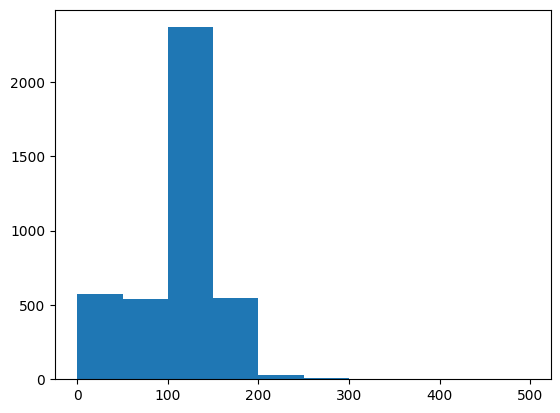

In [33]:
print(f'max len {max_length(train_text)}')
plt.hist([len(s) for s in train_text],bins=[0,50,100,150,200,250,300,350,400,450,498])

In [34]:
max_seq_length=200

In [35]:
train_images

array(['70e11e0fjw1eujqv2t9gwj20h70cetb8.jpg',
       '6a918093jw1eye74q5fruj20go0b5t9q.jpg',
       '8928b6f8gw1dwtca51y1pj.jpg', ...,
       'a115e109jw1ebeeccukczj20hs0no74y.jpg',
       '0065mfIujw1eqnngm1sduj30hs0nqwgm.jpg',
       '83288705gw1dsd1dowpn6j.jpg'], dtype='<U36')

In [36]:
train_text

array(['【日重启火山喷发失踪者搜寻】 29日，时隔9个月后，日本救援队伍重新登上去年9月27日曾喷发的御岳火山，寻找6名失踪者，但当天400人规模的搜寻未有任何结果。去年御岳火山突然喷发，火山灰和飞石致57人遇难，多为登山客，为日本战后伤亡最多火山喷发。上次搜寻因降雪等原因去年10月16日停止。（新浪）',
       '【北京“最牛地下违建”开始回填 工期将持续一个月】25日深夜，北京北锣鼓巷北口，运载沙土的小型货车进进出出，狭窄的纱络胡同内，施工人员正在对被称为“最牛地下违建”的一处私挖地下室进行回填。该地下室共3层，面积700多平方米，最深处达10米，私挖施工已有5年之久。详见：O网页链接',
       '海参崴在元代称永明城。1858年不平等《中俄瑷珲条约》，致使沙俄在1860年6月占领中国重要的港口海参崴. 1945年2月签订“中苏友好同盟条约” ，国民政府代表提出收回大连、海参崴、克叶群岛主权。苏联同意中国收回大连、旅顺，满洲铁路，并达成协议50年以后中国收回海参崴。按约1996年中国应收回海参崴',
       ...,
       '转发&nbsp;&nbsp;卖狗肉违法了， 国家食品药品监督局11月1日开始集中受理狗肉馆举报，举报电话：12331 ．大家扩散出去啊！爱狗狗爱动物！养狗的爱狗的请果断转发，请爱护关心帮助伴侣动物[爱心]',
       '做为贵州孩子，我希望广大社会朋友关注此事：不要等到事情发生之后于事无补，贵州人请强烈顶起.贵州剑河县南旁（新柳村）发生5.5级地震 根据国家地震台消息，这是一周内剑河县发生的第二次地震，震源深度8千米5.5级地震震-希望政府重视此事-，广大朋友请转走，不要在发生汶川的悲剧，请政府提前预防...',
       '【恭喜大家可以戒掉拉面了!拉面剂含大量致癌物质】报道显示:所有兰州拉面馆都在使用拉面剂，拉面剂主要成份是蓬灰，这种化学物质含有大量致癌物质--砷。几乎所有的兰州拉面都用这种制剂来使得面粉更有弹性。新闻:O网页链接 不信的同学,你去吃的时候问问师傅有没有加拉面剂,他肯定回答有'],
      dtype='<U498')

In [38]:
train_df = pd.DataFrame()
train_df['text'] = pd.Series(train_text)
train_df['images'] = pd.Series(train_images)
train_df['labels'] = pd.Series(trainY)
train_df.head()

,text,images,labels
0,【日重启火山喷发失踪者搜寻】 29日，时隔9个月后，日本救援队伍重新登上去年9月27日曾喷发...,70e11e0fjw1eujqv2t9gwj20h70cetb8.jpg,1
1,【北京“最牛地下违建”开始回填 工期将持续一个月】25日深夜，北京北锣鼓巷北口，运载沙土的小...,6a918093jw1eye74q5fruj20go0b5t9q.jpg,1
2,海参崴在元代称永明城。1858年不平等《中俄瑷珲条约》，致使沙俄在1860年6月占领中国重要...,8928b6f8gw1dwtca51y1pj.jpg,0
3,《神州不高兴》作者之一，此书掀起了狂热的反美民族主义情绪!宋晓军在赚了一大笔神州愤青的钱之后...,4c0f04e8gw1evh2paspaqj20ci08cmxg.jpg,0
4,中央电视台《焦点访谈》已经播出，可口可乐承认旗下(果粒橙)含有美国禁用农药[多菌灵]，此菌可...,6a0a36d2jw1e0pki2mnkgj.jpg,0


In [39]:
test_df = pd.DataFrame()
test_df['text'] = pd.Series(test_text)
test_df['images'] = pd.Series(test_images)
test_df['labels'] = pd.Series(testY)
test_df.head()

,text,images,labels
0,【郭美美申请低保，居然获准通过！】郭美美对记者说，她其实就是一个失业人员，并不是大家想象的那...,7fcc7edetw1e6btq03senj20c80gawgs.jpg,0
1,【看病要付钱只有二十几个国家】中国工程院院士戴勀戎：“看病就得付钱。在我们这里好像天经地义。...,8d5c03a7jw1e6r4cc7x02j20by0c40tt.jpg,0
2,东北证券吉林公主岭营业部今天上午被愤怒的股民点燃.,3dc2ac30jw1dx457fr1owj.jpg,0
3,【交通新规】归纳汇总为以下八条，开车的朋友请留意。2013年1月1日开始执行。@于建嵘 @海...,96449d00jw1dyupdyukbkj.jpg,0
4,隐翅虫,5103ab97gw1dwmttofzfoj.jpg,0


In [55]:
IMAGE_DIR = '/content/drive/MyDrive/multimodal-news/weibo-data/images/'

In [69]:
def find_image_from_name_in_dir(image_name, dir):
  for name in glob.glob(dir+'/'+image_name):
    return name

In [84]:
def visualise(index, df):
  path = IMAGE_DIR
  text = df.loc[index]['text']
  image_path = find_image_from_name_in_dir(df.loc[index]['images'],path)
  image = plt.imread(image_path)
  plt.subplot(1, 1, 1)
  #plt.title('债券收益率')
  plt.title(text)
  plt.imshow(image)

# Visualize random tweets

3951


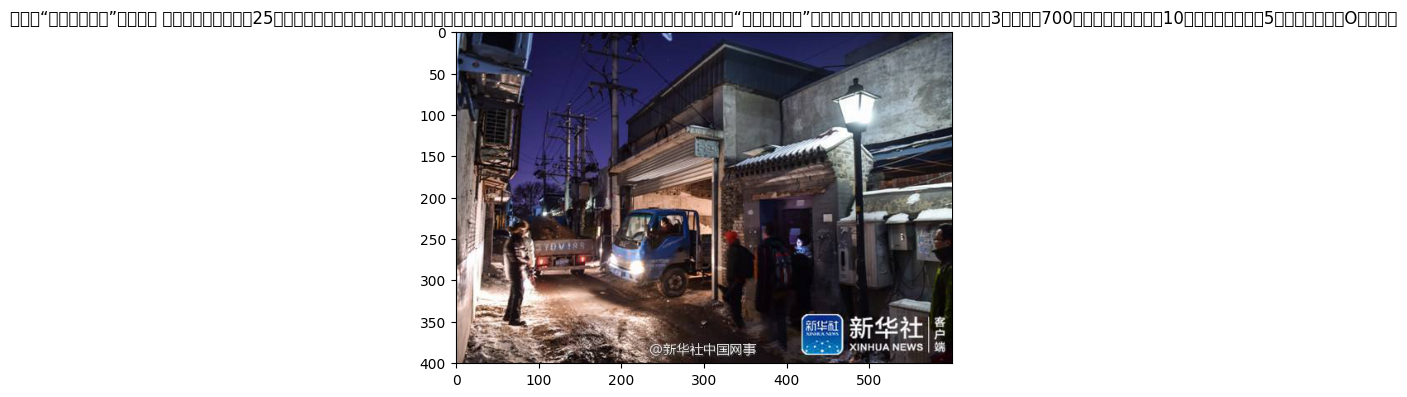

In [85]:
indx = random.randint(0, len(train_df))
print(indx)
visualise(1, train_df)

In [89]:
# Alternate dataframes for modeling
train_df_model = train_df[['text', 'images', 'labels']]
train_df_model['image_path'] = train_df_model['images'].apply(lambda x: find_image_from_name_in_dir(x, IMAGE_DIR))
train_df_model = train_df_model.drop(['images'], axis=1)
train_df_model.head(5)

,text,labels,image_path
0,【日重启火山喷发失踪者搜寻】 29日，时隔9个月后，日本救援队伍重新登上去年9月27日曾喷发...,1,/content/drive/MyDrive/multimodal-news/weibo-d...
1,【北京“最牛地下违建”开始回填 工期将持续一个月】25日深夜，北京北锣鼓巷北口，运载沙土的小...,1,/content/drive/MyDrive/multimodal-news/weibo-d...
2,海参崴在元代称永明城。1858年不平等《中俄瑷珲条约》，致使沙俄在1860年6月占领中国重要...,0,/content/drive/MyDrive/multimodal-news/weibo-d...
3,《神州不高兴》作者之一，此书掀起了狂热的反美民族主义情绪!宋晓军在赚了一大笔神州愤青的钱之后...,0,/content/drive/MyDrive/multimodal-news/weibo-d...
4,中央电视台《焦点访谈》已经播出，可口可乐承认旗下(果粒橙)含有美国禁用农药[多菌灵]，此菌可...,0,/content/drive/MyDrive/multimodal-news/weibo-d...


In [90]:
# Check to make sure all the first_image_id are tied with a path
train_df_model[train_df_model['image_path'].isnull()]

,text,labels,image_path


In [91]:
test_df_model = test_df[['text', 'images', 'labels']]
test_df_model['image_path'] = test_df_model['images'].apply(lambda x: find_image_from_name_in_dir(x, IMAGE_DIR))
test_df_model = test_df_model.drop(['images'], axis=1)
test_df_model.head(5)

,text,labels,image_path
0,【郭美美申请低保，居然获准通过！】郭美美对记者说，她其实就是一个失业人员，并不是大家想象的那...,0,/content/drive/MyDrive/multimodal-news/weibo-d...
1,【看病要付钱只有二十几个国家】中国工程院院士戴勀戎：“看病就得付钱。在我们这里好像天经地义。...,0,/content/drive/MyDrive/multimodal-news/weibo-d...
2,东北证券吉林公主岭营业部今天上午被愤怒的股民点燃.,0,/content/drive/MyDrive/multimodal-news/weibo-d...
3,【交通新规】归纳汇总为以下八条，开车的朋友请留意。2013年1月1日开始执行。@于建嵘 @海...,0,/content/drive/MyDrive/multimodal-news/weibo-d...
4,隐翅虫,0,/content/drive/MyDrive/multimodal-news/weibo-d...


In [92]:
# Check to make sure all the first_image_id are tied with a path
test_df_model[test_df_model['image_path'].isnull()]

,text,labels,image_path


In [93]:
train_df_model['labels'].value_counts()

0    3275
1     795
Name: labels, dtype: int64

In [94]:
test_df_model['labels'].value_counts()

0    840
1    262
Name: labels, dtype: int64

### Save the dataframes for faster access

In [95]:
#Save training df
train_df_model.to_pickle(BASE_SAVE_LOCATION+"/weibo-train.pickle")
#Save testing df
test_df_model.to_pickle(BASE_SAVE_LOCATION+"/weibo-test.pickle")

## Load the dataframes

In [96]:
#Load training df
train_df_model = pd.read_pickle(BASE_SAVE_LOCATION+"/weibo-train.pickle")
#Load testing df
test_df_model = pd.read_pickle(BASE_SAVE_LOCATION+"/weibo-test.pickle")
print(train_df_model.shape, test_df_model.shape)

(4070, 3) (1102, 3)
